In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import string
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score,classification_report,auc,roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from catboost import CatBoostClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV


In [2]:
Feature_df = pd.read_pickle('Feature_df.pkl')
Feature_df.Class.value_counts()

0    269425
1       412
Name: Class, dtype: int64

In [3]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

def plot_confusion_mat(y_test, y_pred):
    import seaborn as sns
    labels = [0, 1]
    cm = confusion_matrix(y_test, y_pred, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
    


#### Replacing Nan Values

In [4]:
df = Feature_df.copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df["mean_Rake"] = df[["Rake", "Rake2"]].mean(axis=1)
df["mean_Frst_AddCash_1&2"] = df[["Frst_AddCash", "Frst_AddCash2"]].mean(axis=1)
df["mean_Frst_AddCash_1&2"].fillna(value=0, inplace=True)
df["max_common_gameAB_%_of_A&B"] = df[["common_gameAB_%_of_A", "common_gameAB_%_of_B"]].max(axis=1)
df['max_common_gameAB_%_of_A&B'].fillna(value=0, inplace=True)
df['A_B_C_BY_D'].fillna(value=0, inplace=True)

In [5]:
df.drop(['P1_regID', 'P2_regID','p1_name','p2_name','Diff_p1block_p2_reg_minutes','Rake','Category','Rake2',
       'Category2','common_games','Frst_AddCash', 'Frst_AddCash2','common_gameAB_%_of_A', 'common_gameAB_%_of_B',
       'A_B_Profit'],axis='columns',inplace=True)


In [6]:
df.isnull().sum()

Name_similarity               9
Contacts_Overlap_%            0
p1_p2_distance_KM             0
Apps_overlap_%                0
A_B_C_BY_D                    0
Class                         0
mean_Rake                     0
mean_Frst_AddCash_1&2         0
max_common_gameAB_%_of_A&B    0
dtype: int64

## Sampling and Splitting the Data
#### Random Undersampling and Upsamling using Smote

In [7]:
%%time

count_class_0, count_class_1 = df.Class.value_counts()
# Divide by class
df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(2000)
df_test_ = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-over-sampling:')
print(df_test_.Class.value_counts())

y = df_test_.Class
X = df_test_.drop(['Class'], axis=1)

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)
print(y_sm.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)
# Number of classes in training Data
print(y_train.value_counts())

Random under-over-sampling:
0    2000
1     412
Name: Class, dtype: int64
0    2000
1    2000
Name: Class, dtype: int64
0    1600
1    1600
Name: Class, dtype: int64
Wall time: 92 ms


### Random Forest

In [8]:
classifier_r = RandomForestClassifier(max_depth = 3,n_estimators = 10, criterion = 'entropy', random_state = 15)
# classifier_r = RandomForestClassifier(max_depth = 4,n_estimators = 10, oob_score = True, n_jobs = -1,random_state =15,max_features = "auto", min_samples_leaf = 5)

classifier_r.fit(X_train, y_train)
# Predicting the Test set results
y_pred_1 = classifier_r.predict(X_train)
print('Training Accuracy :',accuracy_score(y_train,y_pred_1))
y_pred  = classifier_r.predict(X_test)
print('Testing Accuracy :',accuracy_score(y_test,y_pred))

# Making the Confusion Matrix
print("Classification Report[Randomforest]: \n", classification_report(y_test, y_pred))
print("classifier_r.feature_importances_[Randomforest]: \n", classifier_r.feature_importances_)


feature_importance_r = classifier_r.feature_importances_
col = X_train.columns.values.tolist()
feature_df_random = pd.DataFrame(list(zip(col, feature_importance_r)),
               columns =['Col_Name', 'Feature_weight'])
# plot_confusion_mat(y_test, y_pred)
feature_df_random.sort_values('Feature_weight')

Training Accuracy : 0.99125
Testing Accuracy : 0.99125
Classification Report[Randomforest]: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.98      1.00      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

classifier_r.feature_importances_[Randomforest]: 
 [0.00400058 0.00173699 0.13967079 0.01083495 0.3028682  0.05586627
 0.03959036 0.44543187]


,Col_Name,Feature_weight
1,Contacts_Overlap_%,0.001737
0,Name_similarity,0.004001
3,Apps_overlap_%,0.010835
6,mean_Frst_AddCash_1&2,0.039590
5,mean_Rake,0.055866
2,p1_p2_distance_KM,0.139671
4,A_B_C_BY_D,0.302868
7,max_common_gameAB_%_of_A&B,0.445432


In [9]:
param_grid = {
    'criterion' : ['gini','entropy'],
    'n_estimators': [10,20,30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,10],
}

CV_rfc = GridSearchCV(estimator=classifier_r, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

print('\n',CV_rfc.best_estimator_)


 RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=10,
                       random_state=15)


|--- feature_5 <= 2436.92
|   |--- feature_4 <= 1.06
|   |   |--- feature_7 <= 8.48
|   |   |   |--- class: 0.0
|   |   |--- feature_7 >  8.48
|   |   |   |--- class: 1.0
|   |--- feature_4 >  1.06
|   |   |--- feature_4 <= 1.42
|   |   |   |--- class: 1.0
|   |   |--- feature_4 >  1.42
|   |   |   |--- class: 0.0
|--- feature_5 >  2436.92
|   |--- feature_2 <= 102.32
|   |   |--- feature_2 <= 31.37
|   |   |   |--- class: 0.0
|   |   |--- feature_2 >  31.37
|   |   |   |--- class: 0.0
|   |--- feature_2 >  102.32
|   |   |--- class: 1.0



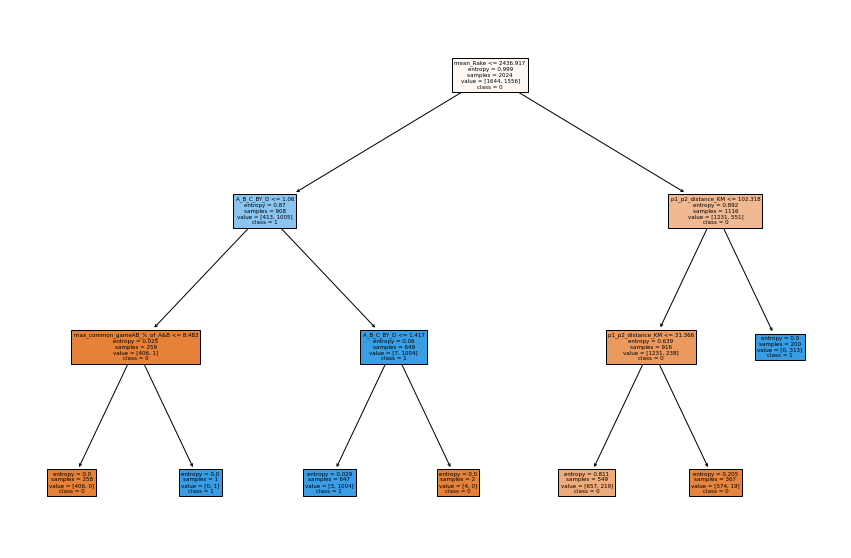

In [10]:
fn = list(X_train.columns)
cn =['0','1']

plt.figure(figsize=(15,10))
tree.plot_tree(classifier_r.estimators_[0],feature_names = fn, 
               class_names=cn,filled=True)

print(tree.export_text(classifier_r.estimators_[0]))


### Logistic Regression

Training Accuracy : 0.983125
Testing Accuracy : 0.98625
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.99      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 433 ms


,Col_Name,Feature_weight
0,Name_similarity,-1.210805
1,Contacts_Overlap_%,-0.145235
2,p1_p2_distance_KM,0.004790
3,Apps_overlap_%,-0.029021
4,A_B_C_BY_D,2.368037
5,mean_Rake,-0.000075
6,mean_Frst_AddCash_1&2,-0.001960
7,max_common_gameAB_%_of_A&B,0.492485


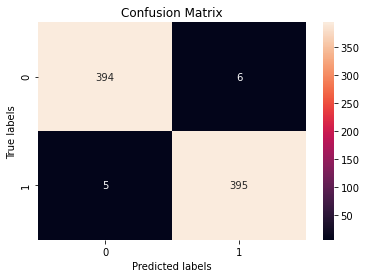

In [11]:
%%time

classifier = LogisticRegression(solver='liblinear').fit(X_train, y_train)
importance = classifier.coef_[0]
# feature_bar(importance)

y_pred_1 = classifier.predict(X_train)
print('Training Accuracy :', accuracy_score(y_train,y_pred_1))

y_pred = classifier.predict(X_test)
print('Testing Accuracy :',accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

col = X_train.columns.values.tolist()
feature_df_logistics = pd.DataFrame(list(zip(col, importance)),
               columns =['Col_Name', 'Feature_weight'])

plot_confusion_mat(y_test, y_pred)
feature_df_logistics

### CatBoost

In [16]:
model_cb = CatBoostClassifier(max_depth=2, iterations=5, 
                              random_state = 10, 
                              eval_metric="F1")

model_cb.fit(X_train, y_train, plot=True, 
             eval_set=(X_test, y_test))

y_pred = model_cb.predict(X_test)
print("classification_repoty[CatBoost]: \n",classification_report(y_test, y_pred))
print("classifier.feature_importances_[CatBoost]: \n", model_cb.feature_importances_)
y_pred_1 = classifier_r.predict(X_train)
print('Training Accuracy :',accuracy_score(y_train,y_pred_1))
print('Testing Accuracy :',accuracy_score(y_test,y_pred))

feature_importance_rr = model_cb.feature_importances_
col = X_train.columns.values.tolist()
feature_df_CatBoost = pd.DataFrame(list(zip(col, feature_importance_rr)),
               columns =['Col_Name', 'Feature_weight'])

feature_df_CatBoost.sort_values('Feature_weight')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.423281
0:	learn: 0.9854624	test: 0.9888199	best: 0.9888199 (0)	total: 786us	remaining: 3.14ms
1:	learn: 0.9854624	test: 0.9888199	best: 0.9888199 (0)	total: 1.88ms	remaining: 2.82ms
2:	learn: 0.9857673	test: 0.9888199	best: 0.9888199 (0)	total: 3.32ms	remaining: 2.22ms
3:	learn: 0.9857673	test: 0.9888199	best: 0.9888199 (0)	total: 4.09ms	remaining: 1.02ms
4:	learn: 0.9876007	test: 0.9900498	best: 0.9900498 (4)	total: 4.8ms	remaining: 0us

bestTest = 0.9900497512
bestIteration = 4

classification_repoty[CatBoost]: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.99      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

classifier.feature_importances_[CatBoost]: 
 [6.59631619e-03 0.00000000e+00 0.00000000e+00 1.48938429e-03
 3.82145522e+01 3.82745

,Col_Name,Feature_weight
1,Contacts_Overlap_%,0.000000
2,p1_p2_distance_KM,0.000000
3,Apps_overlap_%,0.001489
0,Name_similarity,0.006596
5,mean_Rake,0.038275
6,mean_Frst_AddCash_1&2,0.093848
4,A_B_C_BY_D,38.214552
7,max_common_gameAB_%_of_A&B,61.645240
